# **Selecting the best Number of PCA components**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your dataset
your_dataset_path = '/kaggle/input/ransomware/RansomwareData.csv'
df = pd.read_csv(your_dataset_path, header=None)

column_names = [str(i) for i in range(1, 30971)]
df.columns = column_names

# Drop the first column as instructed
df = df.drop(columns=['1'])

# Define the unseen and seen class IDs
unseen_classes_ids = [8, 9, 11]  # IDs of unseen ransomware classes
seen_classes_ids = [1, 2, 3, 4, 5, 6, 7, 10]  # IDs of seen ransomware classes plus goodware
df['Label'] = df['3'].astype(int)  # Ensure the column is of integer type

# Separate the unseen ransomware data
unseen_ransomware_data = df[df['Label'].isin(unseen_classes_ids)]

# Separate the seen ransomware data
seen_ransomware_data = df[~df['Label'].isin(unseen_classes_ids + [0])]

# Goodware samples
goodware_data = df[df['Label'] == 0]
goodware_data = goodware_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Now we split the goodware data based on the count needed for the training set
goodware_train = goodware_data.iloc[:809, :]
goodware_unseen = goodware_data.iloc[809:, :]

train_data = pd.concat([seen_ransomware_data, goodware_train])

# Split the train data into actual training and validation sets
y_train = train_data['2']
X_train = train_data.drop(columns=['2', 'Label', '3'])

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=(257/1257), stratify=y_train, random_state=42  # ~20% for validation to make a total of 1257
)

# Prepare the unseen data
unseen_data = pd.concat([unseen_ransomware_data, goodware_unseen])
y_unseen = unseen_data['2']
X_unseen = unseen_data.drop(columns=['2', 'Label', '3'])

# Apply PCA to reduce dimensionality
num_components = 50  # Adjust the number of components as needed
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_validate_pca = pca.transform(X_validate)
X_unseen_pca = pca.transform(X_unseen)

# Print the top 5 features for each of the first 3 principal components
for i in range(50):
    print(f"Principal component {i+1}:")
    component = pca.components_[i]
    top_features = component.argsort()[-5:][::-1]
    for feature in top_features:
        print(f"    Feature {feature+1} with weight {component[feature]}")

# Convert the numpy arrays back to pandas DataFrame
X_train_pca_df = pd.DataFrame(X_train_pca)
X_validate_pca_df = pd.DataFrame(X_validate_pca)
X_unseen_pca_df = pd.DataFrame(X_unseen_pca)

# Save the DataFrames to CSV files
X_train_pca_df.to_csv('X_train_pca.csv', index=False)
X_validate_pca_df.to_csv('X_validate_pca.csv', index=False)
X_unseen_pca_df.to_csv('X_unseen_pca.csv', index=False)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_pca, y_train)

# Make predictions on the validation set
y_pred_validate = rf_classifier.predict(X_validate_pca)

# Evaluate the performance on the validation set
accuracy_validate = accuracy_score(y_validate, y_pred_validate)
print(f"Accuracy on the validation set: {accuracy_validate}")

# Make predictions on the unseen set
y_pred_unseen = rf_classifier.predict(X_unseen_pca)

# Evaluate the performance on the unseen set
accuracy_unseen = accuracy_score(y_unseen, y_pred_unseen)
print(f"Accuracy on the unseen set: {accuracy_unseen}")

Principal component 1:
    Feature 1893 with weight 0.10319415801282159
    Feature 3665 with weight 0.10260265295811093
    Feature 5284 with weight 0.10247480188625879
    Feature 2542 with weight 0.1022997090482254
    Feature 1327 with weight 0.10196881486779104
Principal component 2:
    Feature 29766 with weight 0.1295162952962991
    Feature 156 with weight 0.12605974823256436
    Feature 28646 with weight 0.11971792670288296
    Feature 18445 with weight 0.11411865519524686
    Feature 123 with weight 0.11190338519170298
Principal component 3:
    Feature 8871 with weight 0.1532427226235702
    Feature 3418 with weight 0.14196718419873014
    Feature 82 with weight 0.12828299862991271
    Feature 170 with weight 0.12490376961004368
    Feature 2602 with weight 0.12247382299346349
Principal component 4:
    Feature 201 with weight 0.12263874520240765
    Feature 1756 with weight 0.11331201692127613
    Feature 168 with weight 0.10168354880330724
    Feature 1947 with weight 0.09

# **Best number of components is 6**

# **Random Forest**

Validation Accuracy: 0.9395161290322581
Unseen Accuracy: 0.9116279069767442
Validation Accuracy: 0.9395161290322581
Unseen Accuracy: 0.9116279069767442


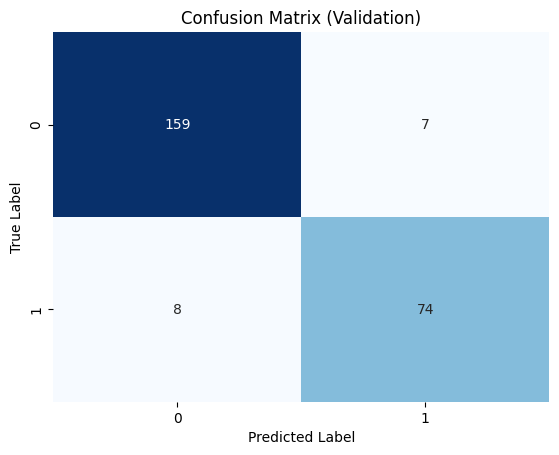

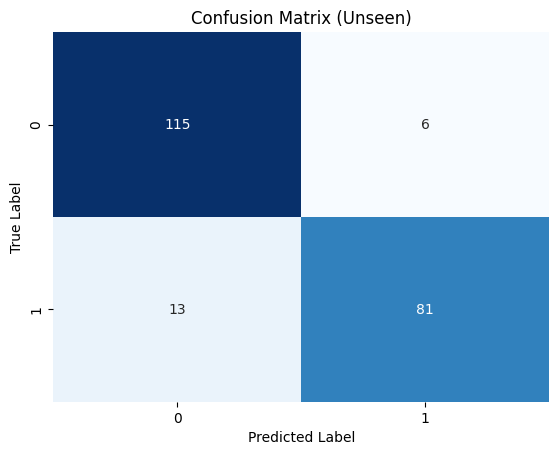

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split ,cross_val_score
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
your_dataset_path = '/kaggle/input/ransomware/RansomwareData.csv'
df = pd.read_csv(your_dataset_path, header=None)

column_names = [str(i) for i in range(1, 30971)]
df.columns = column_names

num_columns = len(df.columns)
df = df.drop(columns=['1'])

num_duplicates = df.duplicated().sum()

df=df.drop_duplicates()

removed_columns = df.columns[(df == 0).mean() >= 0.99]
df = df.drop(columns=removed_columns)

num_removed_columns = len(removed_columns)


unseen_classes_ids = [8, 9, 11]
seen_classes_ids = [1, 2, 3, 4, 5, 6, 7, 10]
df['Label'] = df['3'].astype(int) 
df['2'] = df['2'].astype(int)

unseen_ransomware_data = df[df['Label'].isin(unseen_classes_ids)]
seen_ransomware_data = df[~df['Label'].isin(unseen_classes_ids + [0])]

goodware_data = df[df['Label'] == 0]
goodware_data = goodware_data.sample(frac=1, random_state=42).reset_index(drop=True)

goodware_train = goodware_data.iloc[:809, :]
goodware_unseen = goodware_data.iloc[809:, :]

train_data = pd.concat([seen_ransomware_data, goodware_train])

y_train = train_data['2']
X_train = train_data.drop(columns=['2', 'Label', '3'])

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=(257/1257), stratify=y_train, random_state=42
)

unseen_data = pd.concat([unseen_ransomware_data, goodware_unseen])

y_unseen = unseen_data['2']
X_unseen = unseen_data.drop(columns=['2', 'Label', '3'])

# Apply PCA
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_validate = pca.transform(X_validate)
X_unseen = pca.transform(X_unseen)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred_validate = clf.predict(X_validate)
y_pred_unseen = clf.predict(X_unseen)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_validate, y_pred_validate))
print("Unseen Accuracy:", accuracy_score(y_unseen, y_pred_unseen))


# Make predictions
y_pred_validate = clf.predict(X_validate)
y_pred_unseen = clf.predict(X_unseen)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_validate, y_pred_validate))
print("Unseen Accuracy:", accuracy_score(y_unseen, y_pred_unseen))

# Confusion matrix for validation set
cm = confusion_matrix(y_validate, y_pred_validate)

# Visualization using Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Confusion matrix for unseen set
cm_unseen = confusion_matrix(y_unseen, y_pred_unseen)

# Visualization using Seaborn
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Unseen)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **ANN with AUTOENCODERS**

Validation Accuracy: 0.9233870967741935
Unseen Accuracy: 0.8837209302325582
Validation Accuracy: 0.9233870967741935
Unseen Accuracy: 0.8837209302325582


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


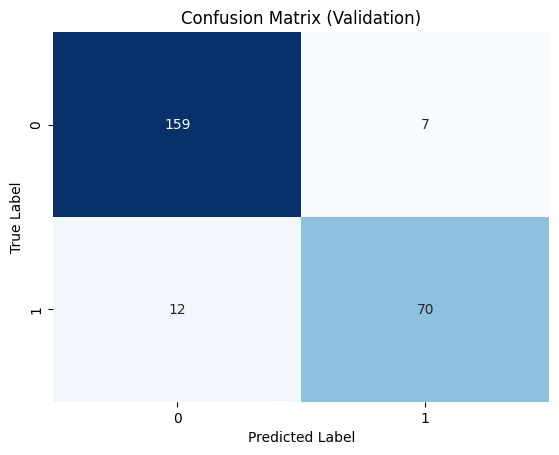

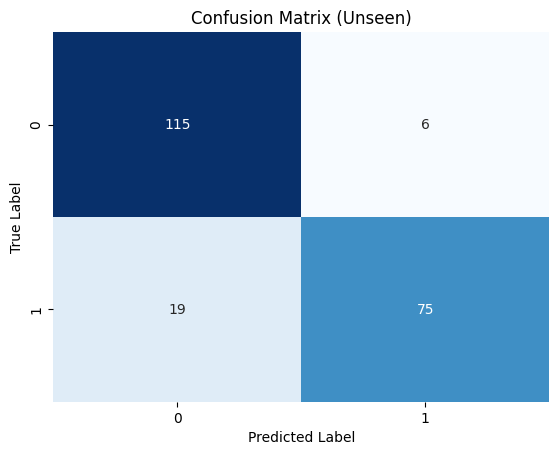

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor, MLPClassifier

# Load your dataset
your_dataset_path = '/kaggle/input/ransomware/RansomwareData.csv'
df = pd.read_csv(your_dataset_path, header=None)

column_names = [str(i) for i in range(1, 30971)]
df.columns = column_names

num_columns = len(df.columns)
df = df.drop(columns=['1'])

num_duplicates = df.duplicated().sum()

df = df.drop_duplicates()

removed_columns = df.columns[(df == 0).mean() >= 0.99]
df = df.drop(columns=removed_columns)

num_removed_columns = len(removed_columns)

unseen_classes_ids = [8, 9, 11]
seen_classes_ids = [1, 2, 3, 4, 5, 6, 7, 10]
df['Label'] = df['3'].astype(int)
df['2'] = df['2'].astype(int)

unseen_ransomware_data = df[df['Label'].isin(unseen_classes_ids)]
seen_ransomware_data = df[~df['Label'].isin(unseen_classes_ids + [0])]

goodware_data = df[df['Label'] == 0]
goodware_data = goodware_data.sample(frac=1, random_state=42).reset_index(drop=True)

goodware_train = goodware_data.iloc[:809, :]
goodware_unseen = goodware_data.iloc[809:, :]

train_data = pd.concat([seen_ransomware_data, goodware_train])

y_train = train_data['2']
X_train = train_data.drop(columns=['2', 'Label', '3'])

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=(257/1257), stratify=y_train, random_state=42
)

unseen_data = pd.concat([unseen_ransomware_data, goodware_unseen])

y_unseen = unseen_data['2']
X_unseen = unseen_data.drop(columns=['2', 'Label', '3'])

# Apply PCA
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_validate = pca.transform(X_validate)
X_unseen = pca.transform(X_unseen)

# Train an Autoencoder
autoencoder = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
autoencoder.fit(X_train, X_train)

# Encode the data using the trained autoencoder
X_train_encoded = autoencoder.predict(X_train)
X_validate_encoded = autoencoder.predict(X_validate)
X_unseen_encoded = autoencoder.predict(X_unseen)

# Train an ANN classifier using the encoded data
clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
clf.fit(X_train_encoded, y_train)

# Make predictions
y_pred_validate = clf.predict(X_validate_encoded)
y_pred_unseen = clf.predict(X_unseen_encoded)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_validate, y_pred_validate))
print("Unseen Accuracy:", accuracy_score(y_unseen, y_pred_unseen))
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Make predictions
y_pred_validate = clf.predict(X_validate_encoded)
y_pred_unseen = clf.predict(X_unseen_encoded)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_validate, y_pred_validate))
print("Unseen Accuracy:", accuracy_score(y_unseen, y_pred_unseen))

# Confusion matrix for validation set
cm = confusion_matrix(y_validate, y_pred_validate)

# Visualization using Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Confusion matrix for unseen set
cm_unseen = confusion_matrix(y_unseen, y_pred_unseen)

# Visualization using Seaborn
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Unseen)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **SVM**

Validation Accuracy: 0.9193548387096774
Unseen Accuracy: 0.8744186046511628


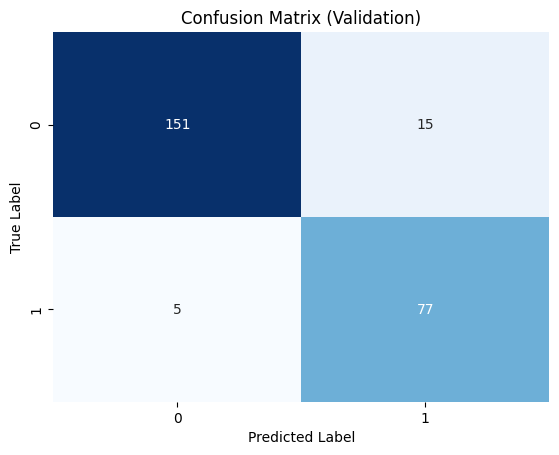

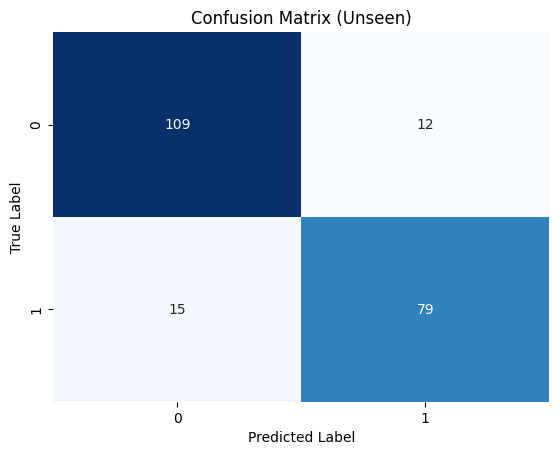

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
your_dataset_path = '/kaggle/input/ransomware/RansomwareData.csv'
df = pd.read_csv(your_dataset_path, header=None)

column_names = [str(i) for i in range(1, 30971)]
df.columns = column_names

df = df.drop(columns=['1'])

df=df.drop_duplicates()

removed_columns = df.columns[(df == 0).mean() >= 0.99]
df = df.drop(columns=removed_columns)

unseen_classes_ids = [8, 9, 11]
seen_classes_ids = [1, 2, 3, 4, 5, 6, 7, 10]
df['Label'] = df['3'].astype(int) 
df['2'] = df['2'].astype(int)

unseen_ransomware_data = df[df['Label'].isin(unseen_classes_ids)]
seen_ransomware_data = df[~df['Label'].isin(unseen_classes_ids + [0])]

goodware_data = df[df['Label'] == 0]
goodware_data = goodware_data.sample(frac=1, random_state=42).reset_index(drop=True)

goodware_train = goodware_data.iloc[:809, :]
goodware_unseen = goodware_data.iloc[809:, :]

train_data = pd.concat([seen_ransomware_data, goodware_train])

y_train = train_data['2']
X_train = train_data.drop(columns=['2', 'Label', '3'])

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=(257/1257), stratify=y_train, random_state=42
)

unseen_data = pd.concat([unseen_ransomware_data, goodware_unseen])

y_unseen = unseen_data['2']
X_unseen = unseen_data.drop(columns=['2', 'Label', '3'])

# Apply PCA
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_validate = pca.transform(X_validate)
X_unseen = pca.transform(X_unseen)

# Train a SVM classifier
clf = SVC(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred_validate = clf.predict(X_validate)
y_pred_unseen = clf.predict(X_unseen)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_validate, y_pred_validate))
print("Unseen Accuracy:", accuracy_score(y_unseen, y_pred_unseen))

# Confusion matrix for validation set
cm = confusion_matrix(y_validate, y_pred_validate)

# Visualization using Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Confusion matrix for unseen set
cm_unseen = confusion_matrix(y_unseen, y_pred_unseen)

# Visualization using Seaborn
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Unseen)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()